# Sentiment Analysis Amazon Reviews - Classificazione a 3 Classi

Questo notebook implementa un sistema di sentiment analysis per recensioni Amazon utilizzando una classificazione a 3 classi (negativo, neutro, positivo).

## Setup Iniziale: Import delle Librerie e Preparazione dei Dati


### Import delle librerie 

In [4]:
# Import librerie base per data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import per text processing e NLP
import re
from collections import Counter
from wordcloud import WordCloud

# Import per machine learning
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Import per deep learning e transformers
import torch
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, Trainer, TrainingArguments,
    EarlyStoppingCallback, set_seed, pipeline
)
from datasets import Dataset, DatasetDict
import evaluate

# Import per sentiment analysis tradizionale
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Import per gestione file e path
import os
import time
import random
from pathlib import Path
from tqdm import tqdm

# Import per API esterne (Gemini)
import google.generativeai as genai
import getpass

### Caricamento Dataset

In [5]:
splits = {'train': 'amazon_reviews_multi_train.csv', 'validation': 'amazon_reviews_multi_valid.csv', 'test': 'amazon_reviews_multi_test.csv'}
train = pd.read_csv("hf://datasets/micguida1/amazon_reviews_multi/" + splits["train"])
validation = pd.read_csv("hf://datasets/micguida1/amazon_reviews_multi/" + splits["validation"])
test = pd.read_csv("hf://datasets/micguida1/amazon_reviews_multi/" + splits["test"])

### Filtraggio dei dati per lingua inglese

In [6]:
# Seleziono solo le recensioni in inglese e creo copie esplicite per evitare SettingWithCopyWarning
train_en = train[train.language == "en"].copy()
valid_en = validation[validation.language == "en"].copy()
test_en = test[test.language == "en"].copy()

## Exploratory Data Analysis (EDA)

### Distribuzione delle classi nei dataset

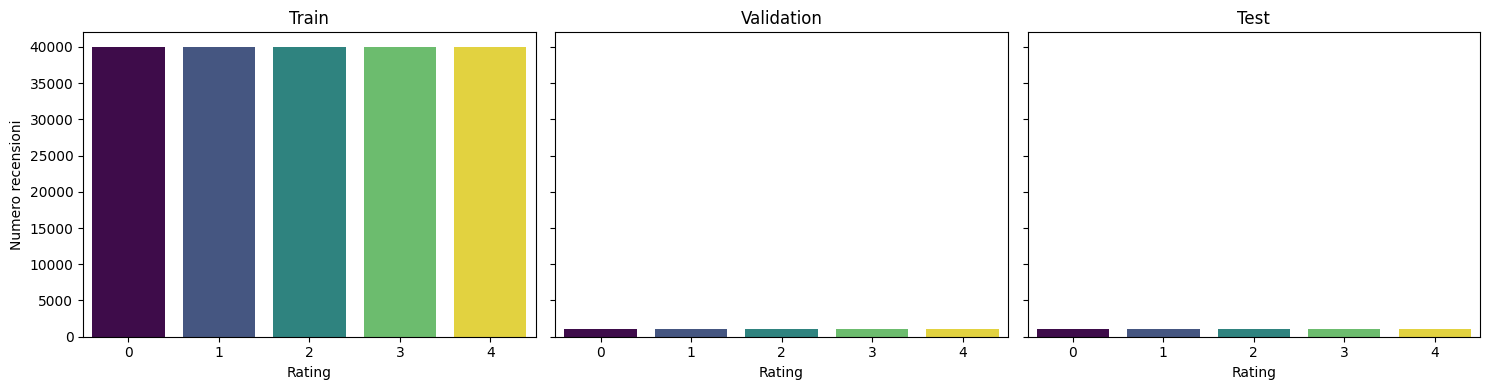

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15,4), sharey=True)

sns.countplot(data=train_en, x="label", hue="label", palette="viridis", legend=False, ax=axes[0])
axes[0].set_title("Train")
axes[0].set_xlabel("Rating")
axes[0].set_ylabel("Numero recensioni")

sns.countplot(data=valid_en, x="label", hue="label", palette="viridis", legend=False, ax=axes[1])
axes[1].set_title("Validation")
axes[1].set_xlabel("Rating")
axes[1].set_ylabel("")

sns.countplot(data=test_en, x="label", hue="label", palette="viridis", legend=False, ax=axes[2])
axes[2].set_title("Test")
axes[2].set_xlabel("Rating")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()

I 3 grafici mostrano la **distribuzione dei rating** (da 0 a 4) nei 3 split del dataset: **trainining, validation e test**.
Nel training set, la distribuzione è uniforme: ogni classe di rating ha lo stesso numero di esempi. Questo implica che il modello NON sarà spinto a favorire una classe rispetto alle altre.
Gli altri 2 split hanno una dimensione ridotta, ma mantengono la stessa proporzione bilanciate. Anche nella valutazione NON ci saranno bias legati a classi sbilanciate. Risulta particolarmente cruciale nel task di sentiment analysis, in quanto le metriche riflettono realmente la capacità del modello di distinguere le diverse polarità.

### Istogrammi per la visualizzazione della distribuzione delle lunghezze delle recensioni

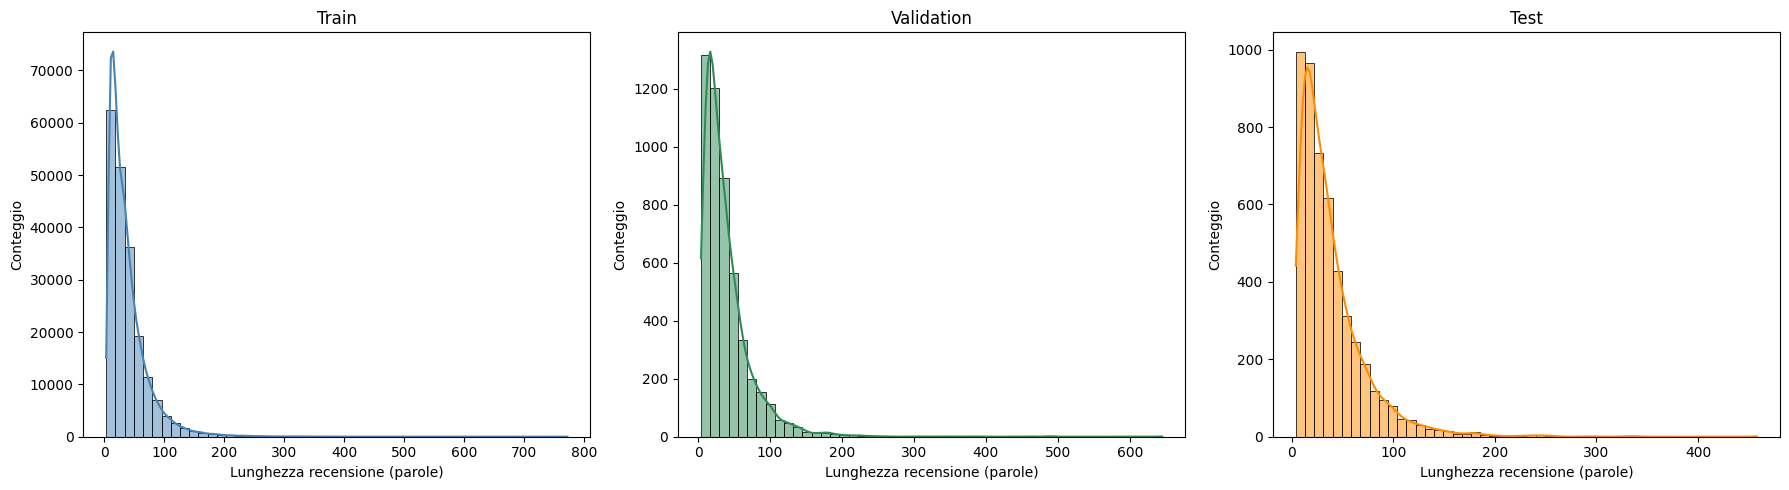

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crea/aggiorna la colonna text_len senza SettingWithCopyWarning
train_en = train_en.assign(text_len=train_en["text"].str.split().str.len())
valid_en = valid_en.assign(text_len=valid_en["text"].str.split().str.len())
test_en  = test_en.assign(text_len=test_en["text"].str.split().str.len())

# Tre istogrammi affiancati, scale indipendenti
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=False)

sns.histplot(train_en["text_len"], bins=50, kde=True, color="steelblue", ax=axes[0])
axes[0].set_title("Train")
axes[0].set_xlabel("Lunghezza recensione (parole)")
axes[0].set_ylabel("Conteggio")

sns.histplot(valid_en["text_len"], bins=50, kde=True, color="seagreen", ax=axes[1])
axes[1].set_title("Validation")
axes[1].set_xlabel("Lunghezza recensione (parole)")
axes[1].set_ylabel("Conteggio")

sns.histplot(test_en["text_len"], bins=50, kde=True, color="darkorange", ax=axes[2])
axes[2].set_title("Test")
axes[2].set_xlabel("Lunghezza recensione (parole)")
axes[2].set_ylabel("Conteggio")

plt.tight_layout()
plt.show()


I 3 istrogrammi mostrano la distribuzione della lunghezza delle recensioni nei tre split: training, validation e test.
Si può notare che la maggior parte delle recensioni è piuttosto breve, la distribuzione è fortemente skewed a dx. Lo stesso vale per Validation e Test set. Confermando cosi che gli split sono coerenti tra loro.

### Boxplot per la visualizzazione della distribuzione delle lunghezze delle recensioni per rating nel training set

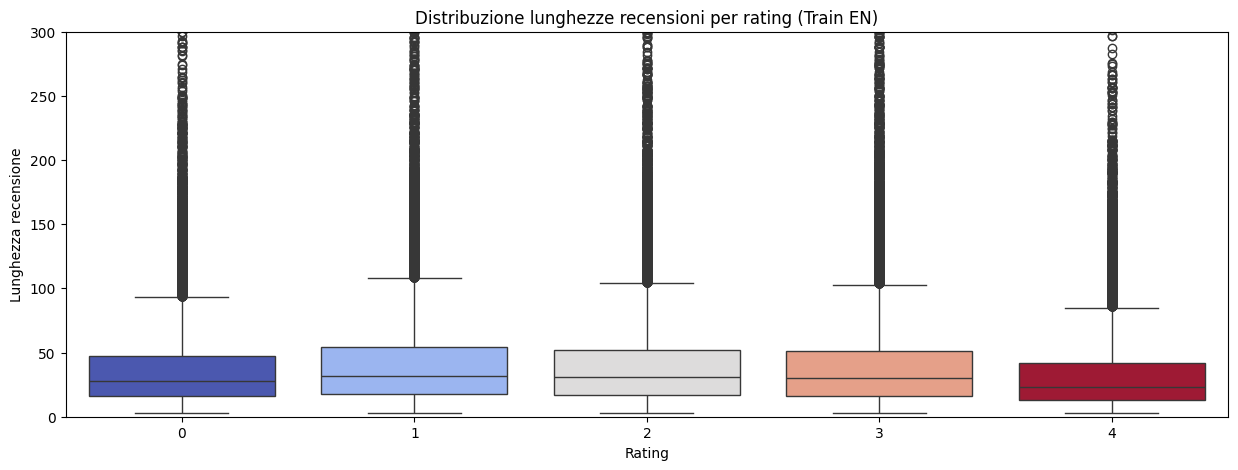

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
sns.boxplot(
    data=train_en,
    x="label",
    y="text_len",
    hue="label",       # serve per usare la palette
    palette="coolwarm",
    legend=False       # evita di mostrare la legenda duplicata
)
plt.title("Distribuzione lunghezze recensioni per rating (Train EN)")
plt.xlabel("Rating")
plt.ylabel("Lunghezza recensione")
plt.ylim(0, 300)  # taglio outlier per renderlo più leggibile
plt.show()


I boxplot mostrano la distribuzione della lunghezza delle recensioni all'interno del training set, per ciascun rating.
Per tutte le classi l'IQR rimane abbastanza simile, per cui la maggior parte delle recensioni ha una lunghezza paragonabile indipendentemente dal rating.
I punti fuori dai whiskers confermano la presenza di outliers già osservata negli istogrammi.
Pertanto la lunghezza del testo risulta una caratteristica poco discriminante tra le diverse classi di rating per predire il sentiment.

## Mappatura delle Classi



### Mappatura dei Rating in Sentiment (3 classi)

Trasformiamo i rating numerici (0-4) in categorie di sentiment più intuitive:
- **neg** (negativo): rating 0-1 stelle 
- **neu** (neutro): rating 2 stelle (3 stelle)
- **pos** (positivo): rating 3-4 stelle (4-5 stelle)

Questa mappatura ci permette di lavorare con 3 classi per l'analisi del sentiment.

In [7]:
def map_sentiment(label):
    if label in [0, 1]:  # 1–2 stars
        return "neg"
    elif label == 2:     # 3 stars
        return "neu"
    else:                # 4–5 stars
        return "pos"

# Use .loc to avoid SettingWithCopyWarning
train_en.loc[:, "sentiment"] = train_en["label"].apply(map_sentiment)
valid_en.loc[:, "sentiment"] = valid_en["label"].apply(map_sentiment)
test_en.loc[:, "sentiment"] = test_en["label"].apply(map_sentiment)

### Word Cloud per le tre classi di sentiment

Visualizziamo le parole più frequenti per ogni classe di sentiment utilizzando delle word cloud colorate:
- **Negativo** (rosso): rating 0-1 stelle
- **Neutro** (nero): rating 2 stelle  
- **Positivo** (verde): rating 3-4 stelle

In [ ]:
#TO DO

## Modelli di Sentiment Analysis



### VADER Sentiment Analyzer


VADER (Valence Aware Dictionary and sEntiment Reasoner) è un modello di sentiment analysis basato su regole e su un lessico appositamente costruito per il linguaggio naturale, in particolare per i testi brevi come recensioni, tweet e commenti online.

VADER assegna a ciascun testo un punteggio di sentiment calcolando la polarità delle parole e delle espressioni presenti, tenendo conto anche di intensificatori, negazioni, punteggiatura ed emoticon. Il risultato è un punteggio "compound" che viene poi mappato in tre classi di sentiment: negativo, neutro e positivo.

Essendo un approccio rule-based, VADER non richiede addestramento su dati specifici e rappresenta una solida baseline per confrontare le prestazioni di modelli più complessi o supervisionati.


=== VADER — TEST SET ===
Accuracy: 0.5892
F1-macro: 0.48224089791094293
              precision    recall  f1-score   support

         neg      0.729     0.530     0.614      2000
         neu      0.199     0.093     0.127      1000
         pos      0.582     0.896     0.706      2000

    accuracy                          0.589      5000
   macro avg      0.503     0.506     0.482      5000
weighted avg      0.564     0.589     0.553      5000



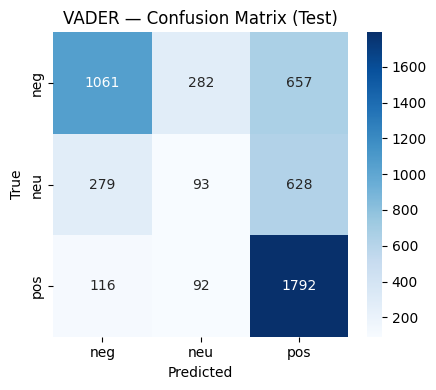

In [8]:
# --- Import ---
import nltk
nltk.download("vader_lexicon", quiet=True)
from nltk.sentiment import SentimentIntensityAnalyzer

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# --- Inizializza VADER ---
sia = SentimentIntensityAnalyzer()

# --- Funzione: compound -> neg/neu/pos ---
def vader_sentiment(text, pos_thresh=0.05, neg_thresh=-0.05):
    score = sia.polarity_scores(text)["compound"]
    if score >= pos_thresh:
        return "pos"
    elif score <= neg_thresh:
        return "neg"
    else:
        return "neu"

# --- Prediction su test ---
test_preds_vader = test_en["text"].apply(vader_sentiment)

print("\n=== VADER — TEST SET ===")
print("Accuracy:", accuracy_score(test_en["sentiment"], test_preds_vader))
print("F1-macro:", f1_score(test_en["sentiment"], test_preds_vader, average="macro"))
print(classification_report(test_en["sentiment"], test_preds_vader, digits=3))

# --- Confusion Matrix ---
CLASSES = ["neg","neu","pos"]
cm = confusion_matrix(test_en["sentiment"], test_preds_vader, labels=CLASSES)
plt.figure(figsize=(4.5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("VADER — Confusion Matrix (Test)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

### **TF-IDF + Logistic Regression vs VADER: training e valutazione sul Test**

In questa sezione si procede all’addestramento e alla valutazione di un modello di apprendimento supervisionato per l’analisi del sentiment, basato su una pipeline composta da:

**TF-IDF (Term Frequency-Inverse Document Frequency):**

Questa tecnica trasforma i testi delle recensioni in vettori numerici che riflettono l’importanza relativa di ciascun termine (inclusi i bigrammi) all’interno del corpus. Le parole molto frequenti ma poco informative (ad esempio, articoli e congiunzioni) vengono penalizzate, mentre termini maggiormente distintivi per il sentiment (come “fantastico” o “pessimo”) acquisiscono un peso superiore.

**Logistic Regression:**

Si utilizza un classificatore lineare che apprende a discriminare tra le classi di sentiment (negativo, neutro, positivo) sfruttando le rappresentazioni TF-IDF. Pur nella sua semplicità, la regressione logistica rappresenta una solida baseline per compiti di classificazione testuale.

**Procedura:**

1. Addestramento della pipeline TF-IDF + Logistic Regression sul training set.
2. Valutazione delle prestazioni sul test set tramite metriche di accuratezza e F1-macro.
3. Confronto dei risultati ottenuti con quelli del modello rule-based VADER.
4. Analisi degli errori commessi da VADER rispetto alla pipeline supervisionata, con esempi concreti.

In [9]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Definizione delle classi target
CLASSES = ["neg", "neu", "pos"]  # Deve corrispondere alla mappatura delle etichette

# Pipeline: TF-IDF (unigrammi e bigrammi) + Regressione Logistica
tfidf_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        min_df=3,
        ngram_range=(1, 2),
        max_features=120_000,
        lowercase=True,
        strip_accents=None  # Mantiene accenti ed emoji, spesso rilevanti per il sentiment
    )),
    ("clf", LogisticRegression(
        max_iter=300,
        class_weight="balanced",
        C=2.0,
        solver="lbfgs",  # Cambiato da liblinear per evitare warning di deprecazione
        random_state=42  # Aggiunto per riproducibilità
    ))
])

# Addestramento del modello sulla porzione di training set in lingua inglese
X_train = train_en["text"].astype(str).fillna("")
y_train = train_en["sentiment"].astype(str)
tfidf_lr.fit(X_train, y_train)

# Valutazione sul test set
X_test = test_en["text"].astype(str).fillna("")
y_test = test_en["sentiment"].astype(str)
y_pred_lr = tfidf_lr.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
f1m_lr = f1_score(y_test, y_pred_lr, average="macro")

# Valutazione del modello VADER sullo stesso test set
y_pred_vader = test_en["text"].astype(str).fillna("").apply(vader_sentiment).values
acc_vader = accuracy_score(y_test, y_pred_vader)
f1m_vader = f1_score(y_test, y_pred_vader, average="macro")

# Stampa dei risultati affiancati
print("=" * 90)
print(f"{'== TF-IDF + Logistic Regression su TEST ==':^45} {'== VADER su TEST ==':^45}")
print(f"{'Accuracy: ' + f'{acc_lr:.3f}':^45} {'Accuracy: ' + f'{acc_vader:.3f}':^45}")
print(f"{'F1-macro: ' + f'{f1m_lr:.3f}':^45} {'F1-macro: ' + f'{f1m_vader:.3f}':^45}")
print("=" * 90)

# Classification reports affiancati con formattazione migliorata
from io import StringIO
import sys

# Cattura il classification report di TF-IDF + LR
old_stdout = sys.stdout
sys.stdout = buffer_lr = StringIO()
print(classification_report(y_test, y_pred_lr, digits=3))
sys.stdout = old_stdout
report_lr = buffer_lr.getvalue()

# Cattura il classification report di VADER
sys.stdout = buffer_vader = StringIO()
print(classification_report(y_test, y_pred_vader, digits=3))
sys.stdout = old_stdout
report_vader = buffer_vader.getvalue()

# Divide i report in righe e pulisce
lines_lr = [line.rstrip() for line in report_lr.strip().split('\n')]
lines_vader = [line.rstrip() for line in report_vader.strip().split('\n')]

# Trova la lunghezza massima per l'allineamento
max_lines = max(len(lines_lr), len(lines_vader))

print()  # Linea vuota per separazione
print(f"{'TF-IDF + Logistic Regression':^55} │ {'VADER':^55}")
print("═" * 55 + " ┼ " + "═" * 55)

for i in range(max_lines):
    left_line = lines_lr[i] if i < len(lines_lr) else ""
    right_line = lines_vader[i] if i < len(lines_vader) else ""
    print(f"{left_line:<55} │ {right_line:<55}")

 == TF-IDF + Logistic Regression su TEST ==                == VADER su TEST ==             
               Accuracy: 0.757                               Accuracy: 0.589               
               F1-macro: 0.721                               F1-macro: 0.482               

             TF-IDF + Logistic Regression               │                          VADER                         
═══════════════════════════════════════════════════════ ┼ ═══════════════════════════════════════════════════════
precision    recall  f1-score   support                 │ precision    recall  f1-score   support                
                                                        │                                                        
         neg      0.822     0.781     0.801      2000   │          neg      0.729     0.530     0.614      2000  
         neu      0.469     0.559     0.510      1000   │          neu      0.199     0.093     0.127      1000  
         pos      0.872     0.832     0

I risultati mostrano una chiara superiorità dell'approccio supervisionato: TF-IDF + Logistic Regression raggiunge 75.6% di accuracy contro il 58.9% di VADER, con un gap di oltre 16 punti percentuali. La differenza è ancora più marcata nell'F1-macro (72.0% vs 48.2%), evidenziando come VADER fallisca soprattutto nella classificazione neutrale (precision 19.9%, recall 9.3%). L'apprendimento supervisionato cattura pattern linguistici domain-specific che sfuggono agli approcci rule-based generalisti.

### Esempi Concreti di Errori Comessi da VADER ma Correttamente Classificati da TF-IDF + Logistic Regression

In [47]:
# Analisi degli errori: esempi dal test set dove TF-IDF+LR è corretto e VADER sbaglia
import pandas as pd
import textwrap
import random
import numpy as np

# PARAMETRI CONFIGURABILI
NUM_EXAMPLES_PER_CLASS = 1  # Numero di esempi da mostrare per ogni classe
RANDOM_SEED = 742           # Seed fisso per riproducibilità (None per seed casuale)
TEXT_WIDTH = 800            # Larghezza massima del testo formattato
TEXT_INDENT = "   "        # Indentazione per il testo

# Creiamo un DataFrame con le predizioni del test set
results_df = pd.DataFrame({
    'text': X_test.values,
    'true_label': y_test.values,
    'tfidf_pred': y_pred_lr,
    'vader_pred': y_pred_vader
})

# Troviamo i casi dove TF-IDF è corretto e VADER sbaglia
tfidf_correct = results_df['true_label'] == results_df['tfidf_pred']
vader_wrong = results_df['true_label'] != results_df['vader_pred']
tfidf_wins = results_df[tfidf_correct & vader_wrong]

print("🎯 Esempi dove TF-IDF+LR è corretto e VADER sbaglia")
print("="*90)
print(f"📋 Configurazione: {NUM_EXAMPLES_PER_CLASS} esempi per classe, seed: {RANDOM_SEED}")
print("="*90)

# Funzione per formattare il testo con indentazione
def format_text(text, width=TEXT_WIDTH, indent=TEXT_INDENT):
    """Formatta il testo con a capo automatico e indentazione"""
    wrapped_lines = textwrap.fill(text, width=width)
    return textwrap.indent(wrapped_lines, indent)

# Generiamo un seed: fisso se specificato, altrimenti casuale
if RANDOM_SEED is not None:
    random_seed = RANDOM_SEED
else:
    random_seed = np.random.randint(0, 10000)
    print(f"🎲 Seed casuale generato: {random_seed}")

# Mostriamo esempi casuali per ogni classe
for sentiment in ['neg', 'neu', 'pos']:
    class_wins = tfidf_wins[tfidf_wins['true_label'] == sentiment]
    
    # Scegliamo NUM_EXAMPLES_PER_CLASS esempi casuali se ne abbiamo abbastanza, altrimenti tutti
    if len(class_wins) >= NUM_EXAMPLES_PER_CLASS:
        examples = class_wins.sample(n=NUM_EXAMPLES_PER_CLASS, random_state=random_seed)
    else:
        examples = class_wins
    
    print(f"\n📊 CLASSE {sentiment.upper()} - TF-IDF+LR vince su VADER:")
    print(f"    (Trovati {len(class_wins)} casi, mostro {len(examples)} esempi)")
    print("-" * 60)
    
    for idx, row in examples.iterrows():
        # Calcoliamo il punteggio VADER per vedere perché ha sbagliato
        vader_score = sia.polarity_scores(row['text'])
        
        print(f"\n📝 TESTO:")
        print(format_text(f'"{row["text"]}"'))
        print(f"   ✅ Vero: {row['true_label']} | ✅ TF-IDF: {row['tfidf_pred']} | ❌ VADER: {row['vader_pred']}")
        print(f"   📈 VADER Score: {vader_score['compound']:.3f} (pos:{vader_score['pos']:.2f}, neu:{vader_score['neu']:.2f}, neg:{vader_score['neg']:.2f})")

print("\n" + "="*90)



🎯 Esempi dove TF-IDF+LR è corretto e VADER sbaglia
📋 Configurazione: 1 esempi per classe, seed: 742

📊 CLASSE NEG - TF-IDF+LR vince su VADER:
    (Trovati 635 casi, mostro 1 esempi)
------------------------------------------------------------

📝 TESTO:
   "Cheaply made  Material looks and feels very cheap."
   ✅ Vero: neg | ✅ TF-IDF: neg | ❌ VADER: neu
   📈 VADER Score: 0.000 (pos:0.00, neu:1.00, neg:0.00)

📊 CLASSE NEU - TF-IDF+LR vince su VADER:
    (Trovati 502 casi, mostro 1 esempi)
------------------------------------------------------------

📝 TESTO:
   "Enjoyed the story, but the art is lacking.  It was an okay ending to the story, but the artwork took me aback. It was quite poor, and not what I’ve come to expect."
   ✅ Vero: neu | ✅ TF-IDF: neu | ❌ VADER: neg
   📈 VADER Score: -0.271 (pos:0.12, neu:0.77, neg:0.12)

📊 CLASSE POS - TF-IDF+LR vince su VADER:
    (Trovati 115 casi, mostro 1 esempi)
------------------------------------------------------------

📝 TESTO:
   "Four Star

Gli esempi evidenziano come VADER, basato su regole generiche, non riesca a catturare le sfumature linguistiche specifiche del dominio e-commerce. Il modello supervisionato TF-IDF+LR, invece, apprende pattern contestuali dai dati di training, risultando più efficace nel riconoscere il sentiment anche in presenza di linguaggio descrittivo neutro o costruzioni sintattiche complesse tipiche delle recensioni online.

## LLM: training e valutazione sul Test Set


In [10]:
# === Gemini evaluation: polarity neg/neu/pos (batch, seed param) ==================
import os, time, re, random
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from IPython.display import display

# --------------------------------------------------------------------------
# 0) Segreti Colab / Config Gemini
# --------------------------------------------------------------------------
try:
    from google.colab import userdata
    GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
except Exception:
    GEMINI_API_KEY = None
if not GEMINI_API_KEY:
    import getpass
    GEMINI_API_KEY = getpass.getpass("Inserisci GEMINI_API_KEY: ")

import google.generativeai as genai
genai.configure(api_key=GEMINI_API_KEY)

MODEL_NAME = "gemini-2.0-flash-lite"  # oppure "gemini-2.5-flash" per più velocità/costi

# --------------------------------------------------------------------------
# 1) Prompt: risposta SOLO in {neg, neu, pos}
# --------------------------------------------------------------------------
INSTRUCTIONS = """Sei un classificatore di sentiment.
Per OGNI recensione, rispondi ESATTAMENTE con UNA sola parola tra:
neg, neu, pos

Regole:
- Niente spiegazioni, niente punteggiatura, niente virgolette.
- Se incerto, rispondi "neu".
- Output: una label per riga, nello stesso ordine delle recensioni.
"""

def build_header() -> str:
    return INSTRUCTIONS

# --------------------------------------------------------------------------
# 2) Chiamata a Gemini in batch (ritorna ['neg'|'neu'|'pos', ...])
# --------------------------------------------------------------------------
LABEL_RE = re.compile(r"\b(neg|neu|pos)\b", re.IGNORECASE)

def _coerce_label(s: str) -> str:
    s = (s or "").strip().lower()
    # pulizia minimale
    s = re.sub(r"[^a-z]", "", s)
    if s in ("neg", "neu", "pos"): return s
    # sinonimi accidentali
    if s.startswith("neg"): return "neg"
    if s.startswith("neu"): return "neu"
    if s.startswith("pos"): return "pos"
    if "negative" in s: return "neg"
    if "neutral"  in s: return "neu"
    if "positive" in s: return "pos"
    return "neu"

def gemini_batch_polarity(reviews: list[str], max_retries=4, sleep_base=0.6) -> list[str]:
    """
    Classifica più recensioni in un'unica chiamata (neg/neu/pos).
    Ritorna una lista di stringhe in {'neg','neu','pos'} nello stesso ordine di input.
    """
    header = build_header()
    lines = [header, "Ora classifica queste recensioni (una label per riga nello stesso ordine):"]
    for i, rev in enumerate(reviews, 1):
        rev_oneline = " ".join(str(rev).split())
        # Format comodo da parsare: riga con indice + testo, poi "Label:"
        lines.append(f"{i}) Review: \"{rev_oneline}\"\nLabel:")

    prompt = "\n".join(lines)

    gen_cfg = genai.GenerationConfig(
        temperature=0,
        max_output_tokens=max(64, 3 * len(reviews) + 16),  # ~3 token/riga + margine
    )
    model = genai.GenerativeModel(MODEL_NAME, generation_config=gen_cfg)

    for attempt in range(max_retries):
        try:
            resp = model.generate_content(prompt)
            raw = (getattr(resp, "text", "") or "").strip()
            # split riga per riga, prendendo la prima occorrenza valida
            out_lines = [l.strip() for l in raw.splitlines() if l.strip()]
            preds = []
            for l in out_lines:
                m = LABEL_RE.search(l)
                if m:
                    preds.append(_coerce_label(m.group(1)))
            if len(preds) < len(reviews):
                preds += ["neu"] * (len(reviews) - len(preds))  # fallback neutro
            return preds[:len(reviews)]
        except Exception:
            # backoff esponenziale + jitter
            time.sleep(sleep_base * (2 ** attempt) + random.random() * 0.1)

    return ["neu"] * len(reviews)  # fallback finale

def gemini_label_polarity(review: str) -> str:
    return gemini_batch_polarity([review])[0]

# --------------------------------------------------------------------------
# 3) Valutazione su TUTTO il test set (robusta, con checkpoint)
# --------------------------------------------------------------------------
from pathlib import Path

CHECKPOINT_PATH = Path("/content/gemini_preds_checkpoint.parquet")  # cambia se vuoi
RESULTS_PATH    = Path("/content/gemini_results.parquet")

# Usa l'intero dataset
texts_all = test_en["text"].astype(str).tolist()
y_true_0_4_all = test_en["label"].astype(int).tolist()

def gold_to_polarity(x: int) -> str:
    if x in (0, 1): return "neg"
    if x == 2:      return "neu"
    return "pos"

y_true_all = [gold_to_polarity(x) for x in y_true_0_4_all]

# Parametri
BATCH_SIZE = 8          # 5–10 è stabile; se vedi rate limit, abbassa
SAVE_EVERY = 200        # salva ogni N batch
SEED = 123

# Riprendi da checkpoint se esiste
start_idx = 0
preds_all = [None] * len(texts_all)
if CHECKPOINT_PATH.exists():
    try:
        ck = pd.read_parquet(CHECKPOINT_PATH)
        # il checkpoint contiene colonne: idx, pred
        for _, row in ck.iterrows():
            preds_all[int(row["idx"])] = row["pred"]
        start_idx = int(ck["idx"].max()) + 1
        print(f"[CKPT] Riprendo da indice {start_idx} (trovate {ck.shape[0]} predizioni).")
    except Exception as e:
        print(f"[CKPT] Errore nel leggere il checkpoint, riparto da zero. Dettagli: {e}")

# Funzione per salvare checkpoint incrementale
def save_ckpt(preds_list, upto_idx):
    rows = [{"idx": i, "pred": p} for i, p in enumerate(preds_list[:upto_idx]) if p is not None]
    if rows:
        pd.DataFrame(rows).to_parquet(CHECKPOINT_PATH, index=False)

# Loop su TUTTE le recensioni
num_batches = (len(texts_all) - start_idx + BATCH_SIZE - 1) // BATCH_SIZE
pbar = tqdm(range(start_idx, len(texts_all), BATCH_SIZE), total=num_batches,
            desc=f"Gemini batch full (batch={BATCH_SIZE})")

bcount = 0
for i in pbar:
    batch = texts_all[i:i+BATCH_SIZE]
    try:
        out = gemini_batch_polarity(batch)
    except Exception as e:
        # retry semplice in caso di errori transienti
        time.sleep(1.0)
        try:
            out = gemini_batch_polarity(batch)
        except Exception as e2:
            print(f"[WARN] Batch {i}-{i+len(batch)} fallito due volte: {e2}. Filler 'neu'.")
            out = ["neu"] * len(batch)

    preds_all[i:i+len(batch)] = out
    bcount += 1

    # salva ogni SAVE_EVERY batch
    if bcount % SAVE_EVERY == 0:
        save_ckpt(preds_all, i + len(batch))

# Salvataggio finale
save_ckpt(preds_all, len(texts_all))

# Verifica che non ci siano buchi; riempi eventuali None con 'neu'
num_none = sum(p is None for p in preds_all)
if num_none:
    print(f"[WARN] {num_none} predizioni mancanti. Riempi con 'neu'.")
    preds_all = [p if p is not None else "neu" for p in preds_all]

# --------------------------------------------------------------------------
# 4) Metriche + salvataggi risultati
# --------------------------------------------------------------------------
CLASSES_3 = ["neg", "neu", "pos"]

print(f"\n=== GEMINI — polarity (full test), size={len(texts_all)}, batch={BATCH_SIZE} ===")
print("Accuracy:", accuracy_score(y_true_all, preds_all))
print("F1-macro:", f1_score(y_true_all, preds_all, average="macro"))
print(classification_report(y_true_all, preds_all, labels=CLASSES_3, digits=3))

# salva risultati completi (utile per analisi errori)
df_out = pd.DataFrame({
    "gold_polarity": y_true_all,
    "pred_polarity": preds_all,
    "text": texts_all
})
df_out.to_parquet(RESULTS_PATH, index=False)
print(f"\n[OK] Salvati i risultati completi in: {RESULTS_PATH}")
print(f"[OK] Checkpoint in: {CHECKPOINT_PATH}")

# Confusion Matrix
cm = confusion_matrix(y_true_all, preds_all, labels=CLASSES_3)
plt.figure(figsize=(5.2,4.6))
plt.imshow(cm, interpolation='nearest')
plt.title(f"Gemini — Confusion Matrix 3-class (full test)")
plt.xticks(range(len(CLASSES_3)), CLASSES_3)
plt.yticks(range(len(CLASSES_3)), CLASSES_3)
for (r, c), v in np.ndenumerate(cm):
    plt.text(c, r, str(v), ha='center', va='center')
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()


Gemini batch full (batch=8):   0%|          | 0/625 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
E0000 00:00:1758818938.411637   19791 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
Gemini batch full (batch=8):   0%|          | 0/625 [01:25<?, ?it/s]


KeyboardInterrupt: 